In [8]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from zipfile import ZipFile

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
ZipFilePath = '/content/drive/MyDrive/pizza_classified_test_train.zip'
DownloadedPath = '/sample/pizza_classified_test_train/'
with ZipFile(ZipFilePath) as zipObj:
  zipObj.extractall(DownloadedPath)

In [11]:
EPOCHS = 30
BATCH_SIZE = 32
image_height = 224
image_width = 224
train_dir = "/sample/pizza_classified_test_train/final folder/train"
valid_dir = "/sample/pizza_classified_test_train/final folder/test"

In [12]:
train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=10,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="categorical")

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=7,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                    )
train_num = train_generator.samples
valid_num = valid_generator.samples

Found 930 images belonging to 2 classes.
Found 371 images belonging to 2 classes.


In [ ]:
def plot_accuracy(hist):
  plt.plot(hist.history["accuracy"])
  plt.plot(hist.history["val_accuracy"])
  plt.title("Model accuracy")
  plt.ylabel("accuracy")
  plt.xlabel("epoch")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()
 
def plot_loss(hist):
  plt.plot(hist.history["loss"])
  plt.plot(hist.history["val_loss"])
  plt.title("Model loss")
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

#ResNet50

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"
pre_trained_resnet_model = hub.KerasLayer(feature_extractor_model, input_shape=(224,224,3),trainable=False)

In [ ]:
num_of_classes = 2
resNet = tf.keras.Sequential([pre_trained_resnet_model,
                             tf.keras.layers.Dense(1001),
                             tf.keras.layers.Dropout(0.1),
                             tf.keras.layers.Dense(16),
                             tf.keras.layers.Dense(num_of_classes)])
resNet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dense_8 (Dense)             (None, 1001)              1003002   
                                                                 
 dropout (Dropout)           (None, 1001)              0         
                                                                 
 dense_9 (Dense)             (None, 16)                16032     
                                                                 
 dense_10 (Dense)            (None, 2)                 34        
                                                                 
Total params: 26,634,917
Trainable params: 1,019,068
Non-trainable params: 25,615,849
_________________________________________________________________


In [ ]:
resNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
resNet.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>

In [ ]:
resnet = resNet.fit(train_generator, validation_data  = valid_generator, epochs=10, verbose=2)

Epoch 1/10
30/30 - 157s - loss: 0.5298 - accuracy: 0.7516 - val_loss: 0.5874 - val_accuracy: 0.7412 - 157s/epoch - 5s/step
Epoch 2/10
30/30 - 154s - loss: 0.6025 - accuracy: 0.7656 - val_loss: 0.5323 - val_accuracy: 0.7520 - 154s/epoch - 5s/step
Epoch 3/10
30/30 - 151s - loss: 0.5538 - accuracy: 0.7645 - val_loss: 0.5362 - val_accuracy: 0.7520 - 151s/epoch - 5s/step
Epoch 4/10
30/30 - 152s - loss: 0.5590 - accuracy: 0.7634 - val_loss: 0.5095 - val_accuracy: 0.7844 - 152s/epoch - 5s/step
Epoch 5/10
30/30 - 192s - loss: 0.5610 - accuracy: 0.7871 - val_loss: 0.5908 - val_accuracy: 0.7682 - 192s/epoch - 6s/step
Epoch 6/10
30/30 - 151s - loss: 0.5562 - accuracy: 0.7753 - val_loss: 0.6528 - val_accuracy: 0.7871 - 151s/epoch - 5s/step
Epoch 7/10
30/30 - 150s - loss: 0.5860 - accuracy: 0.7699 - val_loss: 0.5889 - val_accuracy: 0.6873 - 150s/epoch - 5s/step
Epoch 8/10
30/30 - 155s - loss: 0.5531 - accuracy: 0.7161 - val_loss: 0.5262 - val_accuracy: 0.7008 - 155s/epoch - 5s/step
Epoch 9/10
30/30

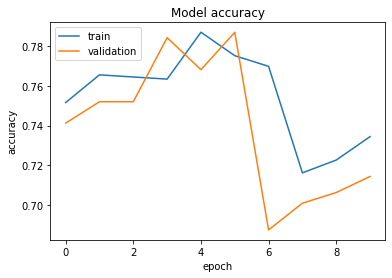

In [ ]:
plot_accuracy(resnet)

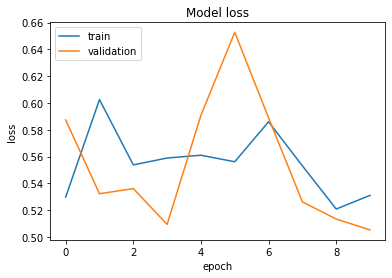

In [ ]:
plot_loss(resnet)

In [ ]:
resNet.evaluate(valid_generator)

12/12 [==============================] - 43s 3s/step - loss: 0.5053 - accuracy: 0.7143


[0.5053405165672302, 0.7142857313156128]

#InceptionV3

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
pre_trained_inception_model = hub.KerasLayer(feature_extractor_model, input_shape=(224,224,3),trainable=False)
num_of_classes = 2
inception_v3 = tf.keras.Sequential([pre_trained_inception_model,      
                              tf.keras.layers.Dense(64),
                              tf.keras.layers.Dropout(0.1),
                              tf.keras.layers.Dense(16),
                              tf.keras.layers.Dense(num_of_classes)])
inception_v3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              23853833  
                                                                 
 dense_17 (Dense)            (None, 64)                64128     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                1040      
                                                                 
 dense_19 (Dense)            (None, 2)                 34        
                                                                 
Total params: 23,919,035
Trainable params: 65,202
Non-trainable params: 23,853,833
_________________________________________________________________


In [ ]:
inception_v3.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
inception = inception_v3.fit(train_generator,  validation_data  = valid_generator, epochs=5, verbose=2)

Epoch 1/5
30/30 - 210s - loss: 1.4556 - accuracy: 0.4118 - val_loss: 0.6202 - val_accuracy: 0.3127 - 210s/epoch - 7s/step
Epoch 2/5
30/30 - 126s - loss: 0.6193 - accuracy: 0.2935 - val_loss: 0.5964 - val_accuracy: 0.3450 - 126s/epoch - 4s/step
Epoch 3/5
30/30 - 127s - loss: 0.5813 - accuracy: 0.2882 - val_loss: 0.5961 - val_accuracy: 0.3369 - 127s/epoch - 4s/step
Epoch 4/5
30/30 - 128s - loss: 0.5624 - accuracy: 0.2839 - val_loss: 0.6126 - val_accuracy: 0.3477 - 128s/epoch - 4s/step
Epoch 5/5
30/30 - 128s - loss: 0.5298 - accuracy: 0.2731 - val_loss: 0.5911 - val_accuracy: 0.3288 - 128s/epoch - 4s/step


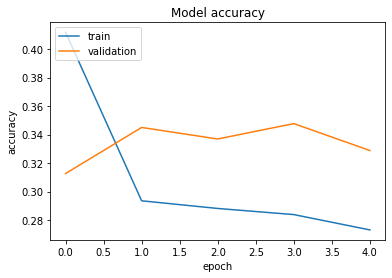

In [ ]:
plot_accuracy(inception)

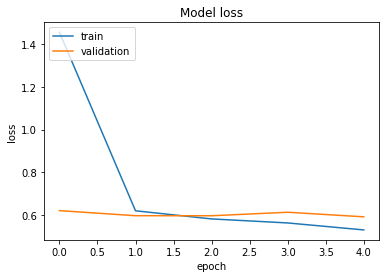

In [ ]:
plot_loss(inception)

In [ ]:
inception_v3.evaluate(valid_generator)

12/12 [==============================] - 35s 3s/step - loss: 0.5911 - accuracy: 0.3288


[0.5911405682563782, 0.328840970993042]